<a href="https://colab.research.google.com/github/louisapraszezynki/2Dtovolume_granulome/blob/main/granulome-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Transformers installation
! pip install transformers[torch] datasets evaluate
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 111.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [1]:
!pip install -U datasets


# Segmentation sémantique d'image

## Charger le dataset : grannulome dataset

Commencer par charger le dataset préparé pour la segmentation d'image, depuis  la librarie de datasets personnelle "Louloubib" sur le hub de Hugging Face (https://huggingface.co/datasets/Louloubib/granulome)

In [13]:
from datasets import load_dataset

ds = load_dataset('Louloubib/granulome')

Séparation du dataset en deux parties : entraînement et test avec la méthode [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split):

In [14]:
ds = ds['train'].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

Observons un exemple :

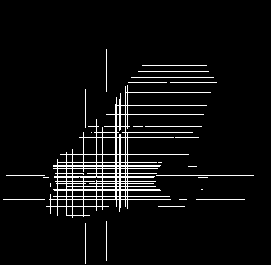

In [20]:
train_ds[160]
train_ds[160]['mask']

Chaque exemple a 2 champs :

- `image`: PIL image du scanner
- `mask`: PIL image de la segmentation par l'opératuer

Visualisation : masque encodé 0-255 (noir/blanc)  
Changement en (0 : background, 1 : masque)

In [21]:
import numpy as np
from PIL import Image

def normalize_image(example):
    numpy_array = np.array(example['mask'])
    example['mask'] = Image.fromarray((numpy_array / 255).astype(np.uint8), mode='L')
    return example

train_ds = train_ds.map(normalize_image)
test_ds = test_ds.map(normalize_image)

Map:   0%|          | 0/288 [00:00<?, ? examples/s]

Map:   0%|          | 0/33 [00:00<?, ? examples/s]

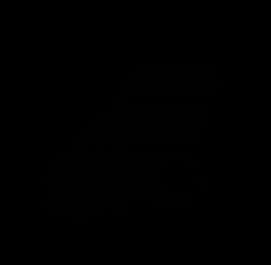

In [22]:
train_ds[160]
train_ds[160]['mask']

Pour faciliter l'obtention du nom de l'étiquette à partir de l'identifiant de l'étiquette par le modèle, créez un dictionnaire qui associe le nom de l'étiquette à un entier, et inversement.

In [23]:
id2label = {1: 'mask', 0: 'background'}
label2id = {'mask': 1, 'background': 0}
num_labels = len(id2label)

## Pré traitement

Les prochaines étapes consistent en charger un pré processeur pour préparer les images et annotations pour le modèle.

In [24]:
from transformers import AutoImageProcessor

checkpoint = "nvidia/mit-b0"
image_processor = AutoImageProcessor.from_pretrained(checkpoint, reduce_labels=True)

preprocessor_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Il est commun d'appliquer des augmentations de données (data augmentations) au dataset pour éviter que le modèle ne fasse d'overfitting. Ici nous allons utiliser la fonction [`ColorJitter`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ColorJitter.html) de [torchvision](https://pytorch.org/vision/stable/index.html) pour aléatoirement changer les propriétés de couleur d'une image.

In [25]:
from torchvision.transforms import ColorJitter

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

Nous créons maintenant deux fonctions de prétraitement pour préparer les images et les annotations pour le modèle. Ces fonctions convertissent les images en `pixel_values` et les annotations en `labels`. Pour l'ensemble d'entraînement, le `jitter` est appliqué avant de passer les images au processeur d'images. Pour le set de test, le processeur d'images rogne et normalise les images, et ne fait que rogner les labels, car aucune augmentation de données n'est appliquée pendant les tests.

In [26]:
def train_transforms(example_batch):
    images = [jitter(x.convert('RGB')) for x in example_batch["image"]]
    labels = [x for x in example_batch["mask"]]
    inputs = image_processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x.convert('RGB') for x in example_batch["image"]]
    labels = [x for x in example_batch["mask"]]
    inputs = image_processor(images, labels)
    return inputs

Pour appliquer le `jitter`sur le dataset entier, nous utilisons la fonction [set_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.set_transform).

In [27]:
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

## Évaluation du modèle

Nous chargeons une méthode d'évaluation depuis la librairie Hugging Face Evaluate [Evaluate](https://huggingface.co/docs/evaluate/index).
Pour notre modèle de segmentation d'image sémantique, nous choisissons d'utiliser la [mean Intersection over Union](https://huggingface.co/spaces/evaluate-metric/accuracy) :

In [28]:
import evaluate

metric = evaluate.load("mean_iou")

Nous créons une fonction pour [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) les métriques. Vos prédictions doivent d'abord être converties en logits, puis redimensionnées pour correspondre à la taille des étiquettes avant de pouvoir appeler [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) :


In [29]:
import torch
from torch import nn
import numpy as np

def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

La fonction `compute_metrics`est prête, nous allons pouvoir paramétrer l'entraînement du modèle.

## Entraînement du modèle

Suivi de la documentation de l'utilisation du [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), avec ce  [tutoriel](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer).

Nous allons pouvoir commencer à entraîner notre modèle. Nous chargons le modèle SegFormer de Hugging Face Transformers avec [AutoModelForSemanticSegmentation](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForSemanticSegmentation):

In [30]:
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer

model = AutoModelForSemanticSegmentation.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Nous allons ensuite :

- Définir les paramètes de l'entraînement ([TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments)).

- Passer les paramètres au [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) avec le modèle, le dataset, les tokenizer, data collector la fonction `compute_metrics`.

- Appeler [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) pour finetuner notre modèle.

Afin de visualiser l'entraînement, il vous faudra un compte wandb.ai et renseigner une clé API (les étapes seront expliquées lorsque la prochaine cellule sera lancée).


In [34]:
training_args = TrainingArguments(
    output_dir="segformer_b0_acouslic_ai",
    learning_rate=6e-5,
    num_train_epochs=50,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    save_total_limit=3,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=1000,
    eval_steps=200,
    logging_steps=1,
    eval_accumulation_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
    hub_strategy="every_save"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()




Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Per Category Iou,Per Category Accuracy
200,0.006400,0.058962,0.497849,0.510345,0.974912,"[0.9748982841133074, 0.02079921314907306]","[0.9994314613967624, 0.021259130819744707]"
400,0.056800,0.058171,0.538676,0.564385,0.971295,"[0.9711966729693022, 0.10615452176291881]","[0.992771556327888, 0.13599848741975945]"
600,0.000500,0.068005,0.540332,0.572193,0.969217,"[0.9690973204982389, 0.11156706334511024]","[0.9901716927297252, 0.15421401165793552]"
800,0.000200,0.053556,0.528888,0.544755,0.974541,"[0.9744816782801938, 0.0832951792686074]","[0.9972247727742692, 0.09228584077326053]"
1000,0.107300,0.066496,0.549681,0.584710,0.969838,"[0.9697019733551823, 0.12965903253567448]","[0.9901651714318778, 0.17925459307902308]"
1200,0.041200,0.058185,0.553760,0.583914,0.971992,"[0.9718686079333526, 0.13565193194750155]","[0.992475015129411, 0.1753532428244669]"
1400,0.000100,0.055063,0.523693,0.542329,0.972336,"[0.9722739878514484, 0.07511198197467024]","[0.9950320752998848, 0.08962499077694976]"
1600,0.053300,0.057188,0.530854,0.548161,0.973989,"[0.9739232304465658, 0.08778423256700166]","[0.9964636780309569, 0.09985796502619346]"
1800,0.051800,0.056393,0.550973,0.577077,0.972896,"[0.9727869514972011, 0.12915889794311436]","[0.9937876931015577, 0.16036578617280306]"
2000,0.050700,0.056421,0.549603,0.573308,0.973524,"[0.9734226771154302, 0.12578246664020276]","[0.9946473187268909, 0.15196819892274774]"


/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Trainer is attempting to log a value of "[0.9748982841133074, 0.02079921314907306]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9994314613967624, 0.021259130819744707]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9711966729693022, 0.10615452176291881]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribu

KeyboardInterrupt: 

Vous pouvez vous créer un compte sur huggingface.co, ce qui vous permettra de sauvegarder le modèle sur le hub, et le réutiliser facilement par la suite. Il vous faudra alors renseigner un token (que vous trouverez sur votre compte) et lancer les cellules suivantes [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) :

Si vous ne souhaitez pas vous créer un compte sur huggingface.co, vous pouvez passer à l'inférence.

In [32]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
trainer.push_to_hub()

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1746730824.668b21d54b80.1840.0:   0%|          | 0.00/1.07M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Louloubib/segformer_b0_acouslic_ai/commit/64e04a02bc36268fb5b5b3130ad7de3cde44e59e', commit_message='End of training', commit_description='', oid='64e04a02bc36268fb5b5b3130ad7de3cde44e59e', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Louloubib/segformer_b0_acouslic_ai', endpoint='https://huggingface.co', repo_type='model', repo_id='Louloubib/segformer_b0_acouslic_ai'), pr_revision=None, pr_num=None)

## Inférence

Maintenant que nous avons adapté le modèle à nos besoins (fine-tune), nous pouvons l'utiliser pour le tester/faire de l'inférence.

Chargement d'un exemple sur lequel nous voulons tester le modèle :

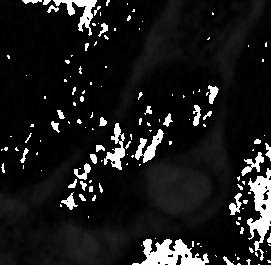

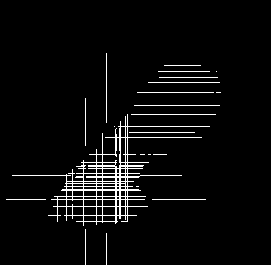

In [38]:
image = ds['test'][14]["image"]
annotation = ds['test'][14]["mask"]
display(image)
display(annotation)

Utilisation de notre modèle et affichage de ses prédictions :

In [39]:
from transformers import pipeline

segmenter = pipeline("image-segmentation", model=model, image_processor=image_processor)

Device set to use cuda:0


In [41]:
results = segmenter(image)
annotation = [result['mask'] for result in results if result['label'] == 'mask'][0]
background = [result['mask'] for result in results if result['label'] == 'background'][0]

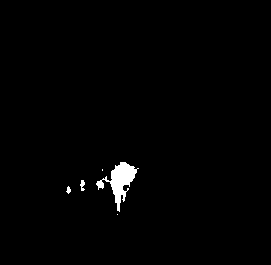

In [42]:
annotation